In [1]:
import matplotlib.pyplot as plt

from utils import *
from models.TSSCD import *

device = device_on()
configs = Configs()
plt.rcParams['font.family'] = ['Arial']
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.unicode_minus'] = False

Uisng cuda device


In [2]:
# LOAD MODEL
model_name = 'TSSCD_Unet'

model_names = ['TSSCD_FCN', 'TSSCD_Unet', 'TSSCD_TransEncoder']
model_instances = {
    'TSSCD_FCN': TSSCD_FCN(configs.input_channels, configs.classes, configs.model_hidden),
    'TSSCD_Unet': TSSCD_Unet(configs.input_channels, configs.classes, configs.model_hidden),
    'TSSCD_TransEncoder': TSSCD_TransEncoder(configs.input_channels, configs.classes, configs.Transformer_hparams)
}

model = model_instances[model_name]

model_idx = '1023'
print(f'model idx: {model_idx}')

model_state_dict = torch.load(os.path.join('models\\model_data', model_name, model_idx + '.pth'), map_location='cuda', weights_only=True)
model = model.to(device)
model.load_state_dict(model_state_dict)
print(model)

tralid = np.load(os.path.join('./models/model_data/dataset', model_idx, 'tralid.npy'))
test = np.load(os.path.join('./models/model_data/dataset', model_idx, 'test.npy'))
print(f'tralid shape: {tralid.shape}, test shape: {test.shape}')


model idx: 1023
TSSCD_Unet(
  (enc0): DoubleConv1d(
    (net): Sequential(
      (0): Conv1d(12, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc1): DownBlock(
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv): DoubleConv1d(
      (net): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (4): BatchNorm1d(128, eps=1e-05, momentum=

In [3]:
# from GradCAM import GradCAM

# class SemanticSegmentationTarget:
#     def __init__(self, category, mask):
#         self.category = category
#         self.mask = torch.from_numpy(mask)
#         if torch.cuda.is_available():
#             self.mask = self.mask.cuda()

#     def __call__(self, model_output):
#         return (model_output[self.category, :] * self.mask).sum()


# def compute_grad_cam(model, inputs, category, target_layers, size=60):
#     """ compute Grad-CAM """
#     preds = model(inputs)
#     mask = torch.argmax(input=preds, axis=1).detach().cpu().numpy()
#     mask_float = np.float32(mask == category)

#     targets = [SemanticSegmentationTarget(category, mask_float)]
#     with GradCAM(model=model,
#                 target_layers=target_layers) as cam:
#         gradcam_values = cam(input_tensor=inputs, targets=targets, size=size)[0]
#     return gradcam_values

# model.eval()
# lc_category = 0 # S. alterniflora
# num_samples, batch_size = test.shape[0], 128
# target_layer = [model.dec1.conv.net[3]]

In [4]:
from captum.attr import LayerGradCam, LayerAttribution

def agg_segmentation_wrapper(inputs, target_class):
    model_output = model(inputs)
    target_output = model_output[:, target_class].sum(dim=1)
    return target_output

def compute_grad_cam(model, inputs, category, target_layer):
    """ compute Grad-CAM """
    lgc = LayerGradCam(lambda inputs: agg_segmentation_wrapper(inputs, category), target_layer)
    gc_attr = lgc.attribute(inputs)
    
    upsampled_gc_attr = LayerAttribution.interpolate(gc_attr, inputs.shape[2:])
    upsampled_gc_attr = upsampled_gc_attr.detach().cpu().numpy()
    return upsampled_gc_attr

model.eval()
lc_category = 0 # S. alterniflora
num_samples, batch_size = test.shape[0], 1
# target_layer = model.dec1.conv.net[3]
if isinstance(model, TSSCD_TransEncoder):
    target_layer = model.decoder[0]
else:
    target_layer = model.dec1.conv.net[-1]

c:\Users\Dell\miniconda3\envs\qwc\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from collections import defaultdict
band_num, class_num = 12, 5
spectral_gradcam_values = {
    class_label: {
        band: [] for band in range(band_num)  # band count
    } for class_label in range(class_num)   # class type count
}
inter_class_gradcam_values = {
    class_label: {
        class_label: {'pos': 0, 'neg': 0} for class_label in range(class_num)
    } for class_label in range(class_num)
}
inter_cls_grad_cam = dict()

# Grad-CAM
heatmaps = list()
# for i in range(0, num_samples, batch_size):
for i in tqdm(range(0, num_samples, batch_size)):
    batch = batch_size if i+batch_size < num_samples else num_samples - i
    # batch size inputs & labels (B, C, T) & (B, 1, T)
    model_inputs, gt_labels = torch.Tensor(test[i:i+batch, :-1, :]).to(device).float(), \
                            torch.Tensor(test[i:i+batch, -1, :]).unsqueeze(1).to(device).long()
    # predictions
    preds = model(model_inputs)
    pre_labels = torch.argmax(input=preds, dim=1, keepdim=True) # （B, 1, T)
    
    unique2idx = defaultdict(list)
    for j in range(batch):
        unique_gt, unique_pres = torch.unique(gt_labels[j]).cpu().numpy(), \
                                torch.unique(pre_labels[j]).cpu().numpy()
        unique_class = tuple(np.union1d(unique_gt, unique_pres))
        unique2idx[unique_class].append(j)
    
    inter_cls_grad_cam_batch = dict()
    for uniq_cls, smp_idxs in dict(unique2idx).items():
        # uniq_cls: (cls1, cls2, ...)
        for target_cls in uniq_cls:
            selected_inputs, selected_labels = model_inputs[smp_idxs, :, :], \
                                            pre_labels[smp_idxs, :, :].cpu().numpy()
            # ====================== inter-class Grad-CAM =========================
            spectral_cam = compute_grad_cam(model, selected_inputs, int(target_cls), target_layer)
            positive_counts, neg_counts = dict(), dict()
            for cls_label in uniq_cls:
                cls_label = int(cls_label)
                positive_counts[cls_label] = int(((spectral_cam > 0) & selected_labels == cls_label).sum())
                neg_counts[cls_label] = int(((spectral_cam < 0) & selected_labels == cls_label).sum())

            inter_cls_grad_cam_batch[int(target_cls)] = {
                'positive_counts': positive_counts,
                'negative_counts': neg_counts,
            }
            # ====================== spectral Grad-CAM ==============================
            # target class var : **target_cls**
            band_means = selected_inputs.mean(dim=(0, 2), keepdim=True)  # (1, C, 1)
            for band in range(band_num):
                # band_only_inputs = band_means.repeat(selected_inputs.size(0), 1, selected_inputs.size(2))
                band_only_inputs = torch.zeros_like(selected_inputs)
                band_only_inputs[:, band, :] = selected_inputs[:, band, :]
                spectral_cam = compute_grad_cam(model, band_only_inputs, int(target_cls), target_layer)
                
                # spectral_cam = np.clip(spectral_cam, -1, 1)
                # spectral_cam = spectral_cam / (np.max(np.abs(spectral_cam)) + 1e-7)
                
                spectral_gradcam_values[int(target_cls)][band].append(spectral_cam)

    inter_cls_grad_cam[f'batch_idx_{i}'] = inter_cls_grad_cam_batch
    
# clarify data format
# spectral-gradcam
for class_label, band_dict in spectral_gradcam_values.items():
    for band_idx, gradcam_values_list in band_dict.items():
        spectral_gradcam_values[class_label][band_idx] = np.concatenate(gradcam_values_list, axis=0)
# inter-class-gradcam
for batch_idx, data in inter_cls_grad_cam.items():
    for uniq_cls_label, pos_neg_counts in data.items():
        for contr_lbl, counts in pos_neg_counts['positive_counts'].items():
            inter_class_gradcam_values[uniq_cls_label][contr_lbl]['pos'] += counts
        for contr_lbl, counts in pos_neg_counts['negative_counts'].items():
            inter_class_gradcam_values[uniq_cls_label][contr_lbl]['neg'] += counts

100%|██████████| 3866/3866 [09:14<00:00,  6.97it/s]


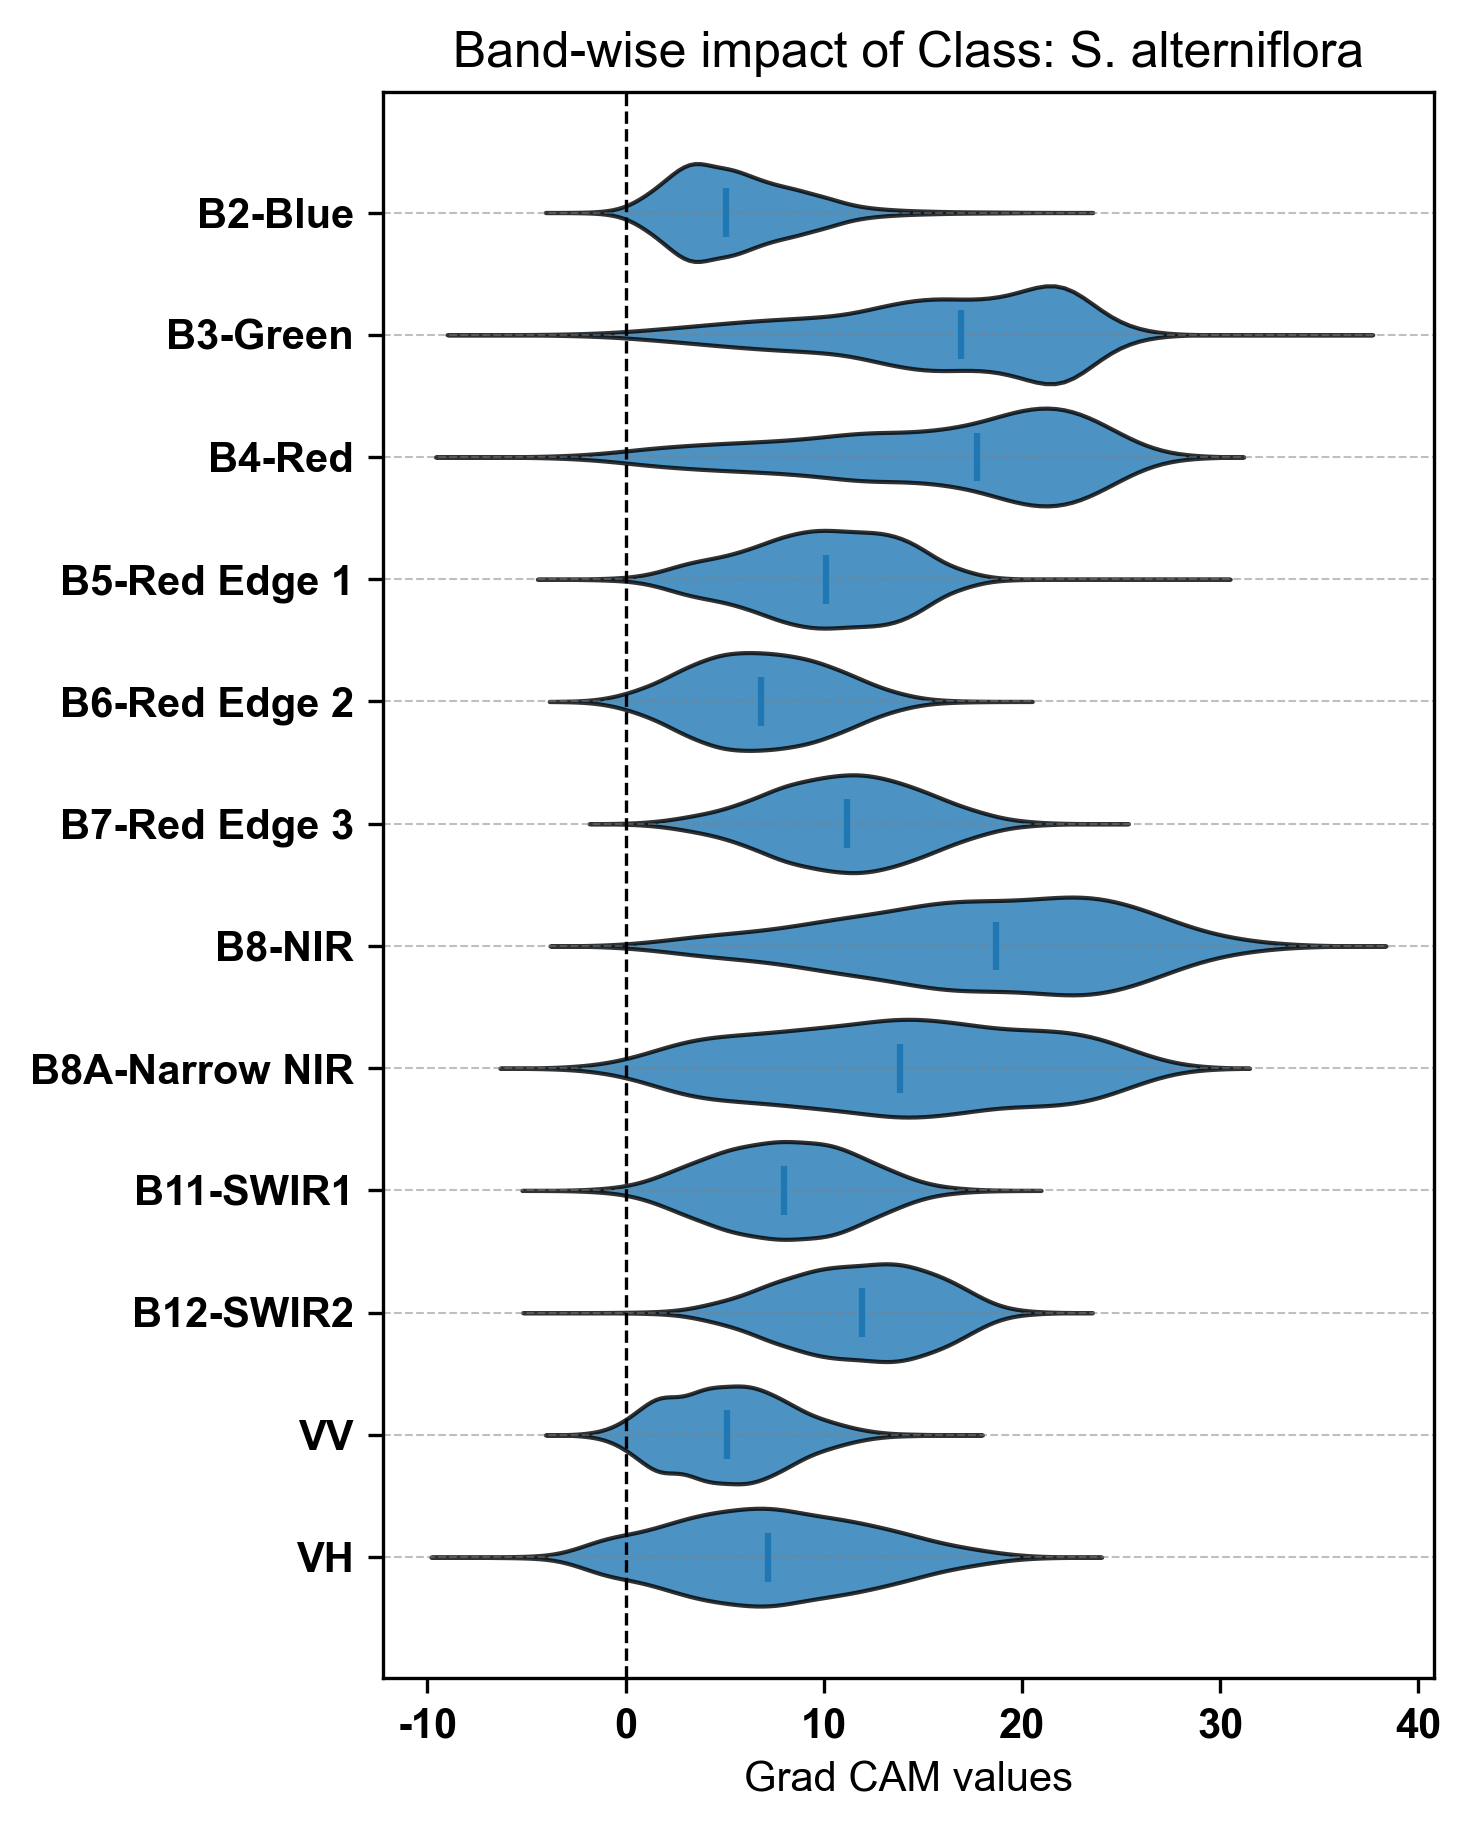

In [6]:
class_label = 0           # S. alterniflora

band_names = ['B2-Blue', 'B3-Green', 'B4-Red', 'B5-Red Edge 1', 'B6-Red Edge 2', 'B7-Red Edge 3', 'B8-NIR', 'B8A-Narrow NIR', 'B11-SWIR1', 'B12-SWIR2', 'VV', 'VH']
band_num    = len(spectral_gradcam_values[class_label])

grad_cam_of_band = [spectral_gradcam_values[class_label][i].reshape(-1)
                 for i in range(band_num)]

fig, ax = plt.subplots(figsize=(5, band_num * 0.35 + 2), dpi=300)

parts = ax.violinplot(
    grad_cam_of_band,
    positions=np.arange(len(band_names)),   # y 轴位置
    vert=False,                             # 横向
    widths=0.8,
    showmeans=False, showmedians=True, showextrema=False,
    bw_method=0.2
)

sign = -1
for pc in parts['bodies']:
    # verts = pc.get_paths()[0].vertices
    # y_center = verts[:, 1].mean()
    # mask = sign * (verts[:, 1] - y_center) < 0
    # verts[mask, 1] = y_center
    
    pc.set_facecolor('#1f77b4')
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)
    
ax.grid(which='major', axis='y', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

ax.set_yticks(np.arange(len(band_names)))
ax.set_yticklabels(band_names)
ax.set_xlabel('Grad CAM values')
ax.set_ylabel('')
ax.axvline(0, ls='--', lw=0.8, color='black')

ax.set_title('Band-wise impact of Class: S. alterniflora')
# ax.set_title('Band-wise impact of Class: Bare flats')
# ax.set_title('Band-wise impact of Class: Water')
# ax.set_title('Band-wise impact of Class: Herbicide-control litter')

ax.invert_yaxis()
# ax.set_xlim(-1.5, 1.5)

plt.tight_layout()
plt.show()
